# Failed Banks vs. Macro Factors

## Failed Bank List

In [ ]:
import pandas as pd

banks = pd.read_csv("banks.csv", parse_dates=["Failure Date"])
banks["Date"] = banks["Failure Date"].dt.to_period("M").dt.to_timestamp()
banks_monthly = banks.groupby("Date").size().reset_index(name="Failed Banks")

# Fill in missing months
full_range = pd.date_range(start = banks_monthly["Date"].min(), end = banks_monthly["Date"].max(), freq = "MS")
banks_monthly = pd.merge(pd.DataFrame({"Date": full_range}), banks_monthly, on = "Date", how = "left")
banks_monthly["Failed Banks"] = banks_monthly["Failed Banks"].fillna(0)

# Filter to start from 1995-01-01 to match with Recession Data
banks_monthly = banks_monthly[banks_monthly["Date"] >= "1995-01-01"]
banks_monthly.head()

,Date,Failed Banks
729,1995-01-01,1.0
730,1995-02-01,0.0
731,1995-03-01,2.0
732,1995-04-01,1.0
733,1995-05-01,2.0


In [ ]:
recession_indicator = pd.read_csv("USREC.csv")
print(recession_indicator.columns)
print(banks_monthly.columns)

recession_indicator["observation_date"] = pd.to_datetime(recession_indicator["observation_date"])
recession_indicator = recession_indicator.rename(columns = {"observation_date": "Date", "USREC": "Recession"})

merged_data = pd.merge(banks_monthly, recession_indicator, on = "Date", how = "left")
merged_data["Recession"] = merged_data["Recession"].fillna(0)

Index(['observation_date', 'USREC'], dtype='object')
Index(['Date', 'Failed Banks'], dtype='object')


In [ ]:
merged_data

,Date,Failed Banks,Recession
0,1995-01-01,1.0,0
1,1995-02-01,0.0,0
2,1995-03-01,2.0,0
3,1995-04-01,1.0,0
4,1995-05-01,2.0,0
...,...,...,...
260,2016-09-01,1.0,0
261,2016-10-01,0.0,0
262,2016-11-01,0.0,0
263,2016-12-01,0.0,0


## Load Macro Factors

In [ ]:
# CPI
cpi = pd.read_csv("CPIAUCSL.csv")
cpi = cpi.rename(columns = {"observation_date": "Date", "CPIAUCSL": "CPI"})
cpi["Date"] = pd.to_datetime(cpi["Date"])
cpi = cpi[["Date", "CPI"]]

# Unemployment
unrate = pd.read_csv("UNRATE.csv")
unrate = unrate.rename(columns = {"observation_date": "Date", "UNRATE": "Unemployment"})
unrate["Date"] = pd.to_datetime(unrate["Date"])
unrate = unrate[["Date", "Unemployment"]]

# GDPC1
gdp = pd.read_csv('GDPC1.csv')
gdp = gdp.rename(columns = {"observation_date": "Date", "GDPC1": "GDP"})
gdp["Date"] = pd.to_datetime(gdp["Date"])
gdp = gdp[["Date", "GDP"]]

# INDPRO
ind = pd.read_csv('INDPRO.csv')
ind = ind.rename(columns = {"observation_date": "Date", "INDPRO": "IND"})
ind["Date"] = pd.to_datetime(ind["Date"])
ind = ind[["Date", "IND"]]

# ICSA
icsa = pd.read_csv('ICSA.csv')
icsa = icsa.rename(columns = {"observation_date": "Date"})
icsa["Date"] = pd.to_datetime(icsa["Date"])
icsa = icsa[["Date", "ICSA"]]
icsa = icsa.set_index("Date").sort_index()
icsa = icsa.resample('D').ffill()

print(merged_data.columns)

Index(['Date', 'Failed Banks', 'Recession'], dtype='object')


In [ ]:
merged_data = pd.merge(merged_data, cpi, on = "Date", how = "left")
merged_data = pd.merge(merged_data, unrate, on ="Date", how = "left")
merged_data = pd.merge(merged_data, gdp, on = "Date", how = "left")
merged_data = pd.merge(merged_data, ind, on = "Date", how = "left")
merged_data = pd.merge(merged_data, icsa, on = "Date", how = "left")

print(merged_data.columns)

Index(['Date', 'Failed Banks', 'Recession', 'CPI', 'Unemployment', 'GDP',
       'IND', 'ICSA'],
      dtype='object')


In [ ]:
merged_data.isna().sum()

,0
Date,0
Failed Banks,0
Recession,0
CPI,0
Unemployment,0
GDP,176
IND,0
ICSA,1


In [ ]:
import numpy as np

merged_data["CPI_YoY"] = merged_data["CPI"].pct_change(periods=12) * 100
merged_data["Unemployment"] = merged_data["Unemployment"].ffill()
merged_data['GDP_YoY'] = merged_data['GDP'].pct_change(4) * 100
merged_data['IND_YoY'] = merged_data['IND'].pct_change(12) * 100
merged_data['ICSA_smooth'] = -np.log(merged_data['ICSA'].rolling(7).mean())

merged_data.isna().sum()

<ipython-input-56-8b7975f3b052>:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged_data['GDP_YoY'] = merged_data['GDP'].pct_change(4) * 100


,0
Date,0
Failed Banks,0
Recession,0
CPI,0
Unemployment,0
GDP,176
IND,0
ICSA,1
CPI_YoY,12
GDP_YoY,4


## FB vs. CPI

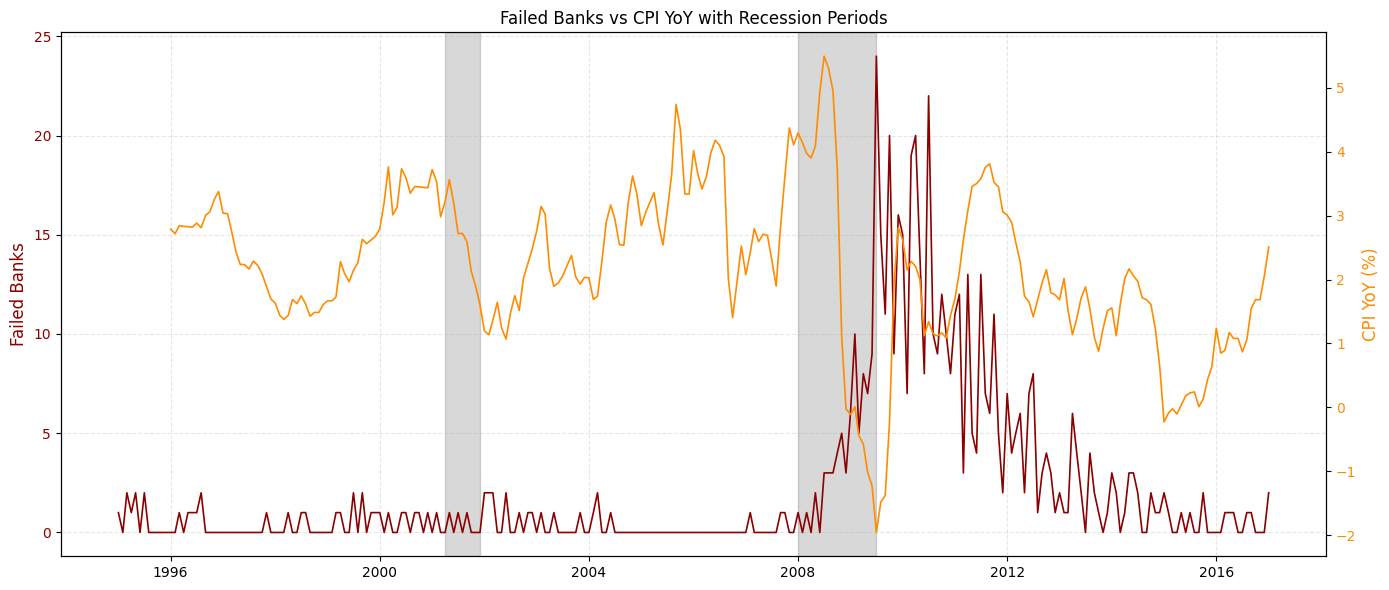

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and clean bank failures
banks = pd.read_csv("banks.csv", parse_dates = ["Failure Date"])
banks["Date"] = banks["Failure Date"].dt.to_period("M").dt.to_timestamp()
banks_monthly = banks.groupby("Date").size().reset_index(name = "Failed Banks")

# Fill in missing months
full_range = pd.date_range(start = banks_monthly["Date"].min(), end = banks_monthly["Date"].max(), freq = "MS")
banks_monthly = pd.merge(pd.DataFrame({"Date": full_range}), banks_monthly, on = "Date", how = "left")
banks_monthly["Failed Banks"] = banks_monthly["Failed Banks"].fillna(0)
banks_monthly = banks_monthly[banks_monthly["Date"] >= "1995-01-01"]

# Load CPI and compute YoY
cpi = pd.read_csv("CPIAUCSL.csv", parse_dates = ["observation_date"])
cpi = cpi.rename(columns = {"observation_date": "Date", "CPIAUCSL": "CPI"})
cpi["CPI_YoY"] = cpi["CPI"].pct_change(periods = 12) * 100

# Load recession indicator
recessions = pd.read_csv("USREC.csv", parse_dates = ["observation_date"])
recessions = recessions.rename(columns = {"observation_date": "Date", "USREC": "Recession"})

# Merge
merged_data = pd.merge(banks_monthly, cpi[["Date", "CPI_YoY"]], on = "Date", how = "left")
merged_data = pd.merge(merged_data, recessions, on = "Date", how = "left")
merged_data["Recession"] = merged_data["Recession"].fillna(0)

# Plot
def plot_banks_vs_cpi(title: str):
    fig, ax1 = plt.subplots(figsize = (14, 6))

    # Left axis: Failed Banks
    ax1.plot(merged_data["Date"], merged_data["Failed Banks"], label = "Failed Banks", color = "darkred", linewidth = 1.2)
    ax1.set_ylabel("Failed Banks", color = "darkred", fontsize = 12)
    ax1.tick_params(axis = 'y', labelcolor = "darkred")
    ax1.grid(True, linestyle = "--", alpha = 0.3)

    # Right axis: CPI YoY
    ax2 = ax1.twinx()
    ax2.plot(merged_data["Date"], merged_data["CPI_YoY"], label = "CPI YoY (%)", color = "darkorange", linewidth=1.2)
    ax2.set_ylabel("CPI YoY (%)", color = "darkorange", fontsize = 12)
    ax2.tick_params(axis = 'y', labelcolor = "darkorange")

    # Shade recession periods in grey
    recession_mask = merged_data["Recession"] == 1
    for i in range(1, len(recession_mask)):
        if recession_mask.iloc[i] and not recession_mask.iloc[i - 1]:
            start = merged_data["Date"].iloc[i]
        if recession_mask.iloc[i - 1] and not recession_mask.iloc[i]:
            end = merged_data["Date"].iloc[i]
            ax1.axvspan(start, end, color = "gray", alpha = 0.3)

    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_banks_vs_cpi("Failed Banks vs CPI YoY with Recession Periods")


## FB vs. Unemployment

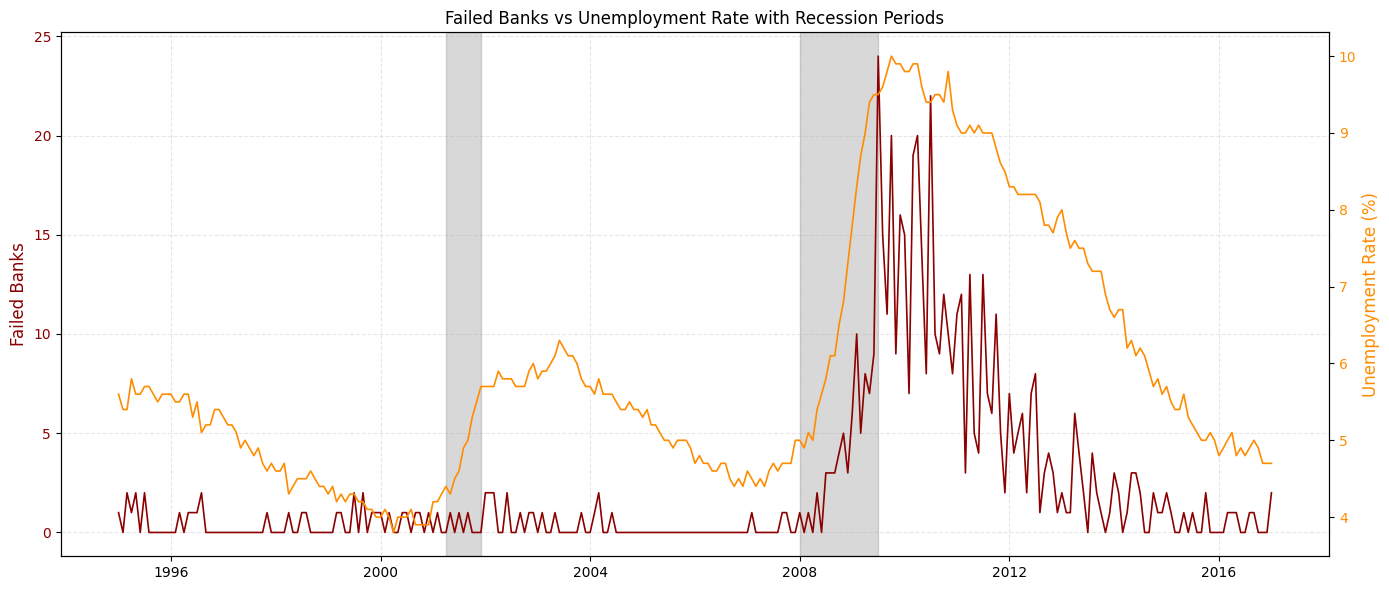

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and clean bank failures
banks = pd.read_csv("banks.csv", parse_dates = ["Failure Date"])
banks["Date"] = banks["Failure Date"].dt.to_period("M").dt.to_timestamp()
banks_monthly = banks.groupby("Date").size().reset_index(name = "Failed Banks")

# Fill in missing months w
full_range = pd.date_range(start = banks_monthly["Date"].min(), end = banks_monthly["Date"].max(), freq = "MS")
banks_monthly = pd.merge(pd.DataFrame({"Date": full_range}), banks_monthly, on = "Date", how = "left")
banks_monthly["Failed Banks"] = banks_monthly["Failed Banks"].fillna(0)
banks_monthly = banks_monthly[banks_monthly["Date"] >= "1995-01-01"]

# Load CPI and compute YoY
cpi = pd.read_csv("CPIAUCSL.csv", parse_dates = ["observation_date"])
cpi = cpi.rename(columns = {"observation_date": "Date", "CPIAUCSL": "CPI"})
cpi["CPI_YoY"] = cpi["CPI"].pct_change(periods=12) * 100

# Load recession indicator
recessions = pd.read_csv("USREC.csv", parse_dates = ["observation_date"])
recessions = recessions.rename(columns = {"observation_date": "Date", "USREC": "Recession"})

# Load Unemployment Rate
unrate = pd.read_csv("UNRATE.csv", parse_dates = ["observation_date"])
unrate = unrate.rename(columns = {"observation_date": "Date", "UNRATE": "Unemployment"})

# Merge
merged_data = pd.merge(banks_monthly, cpi[["Date", "CPI_YoY"]], on = "Date", how = "left")
merged_data = pd.merge(merged_data, recessions, on = "Date", how = "left")
merged_data = pd.merge(merged_data, unrate[["Date", "Unemployment"]], on = "Date", how = "left")
merged_data["Recession"] = merged_data["Recession"].fillna(0)

# Plot
def plot_banks_vs_unemployment(title: str):
    fig, ax1 = plt.subplots(figsize = (14, 6))

    ax1.plot(merged_data["Date"], merged_data["Failed Banks"], color = "darkred", linewidth = 1.2)
    ax1.set_ylabel("Failed Banks", color = "darkred", fontsize = 12)
    ax1.tick_params(axis = 'y', labelcolor = "darkred")
    ax1.grid(True, linestyle = "--", alpha = 0.3)

    ax2 = ax1.twinx()
    ax2.plot(merged_data["Date"], merged_data["Unemployment"], color = "darkorange", linewidth = 1.2)
    ax2.set_ylabel("Unemployment Rate (%)", color = "darkorange", fontsize=12)
    ax2.tick_params(axis = 'y', labelcolor = "darkorange")

    recession_mask = merged_data["Recession"] == 1
    for i in range(1, len(recession_mask)):
        if recession_mask.iloc[i] and not recession_mask.iloc[i - 1]:
            start = merged_data["Date"].iloc[i]
        if recession_mask.iloc[i - 1] and not recession_mask.iloc[i]:
            end = merged_data["Date"].iloc[i]
            ax1.axvspan(start, end, color = "gray", alpha = 0.3)

    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_banks_vs_unemployment("Failed Banks vs Unemployment Rate with Recession Periods")

## FB vs. GDP

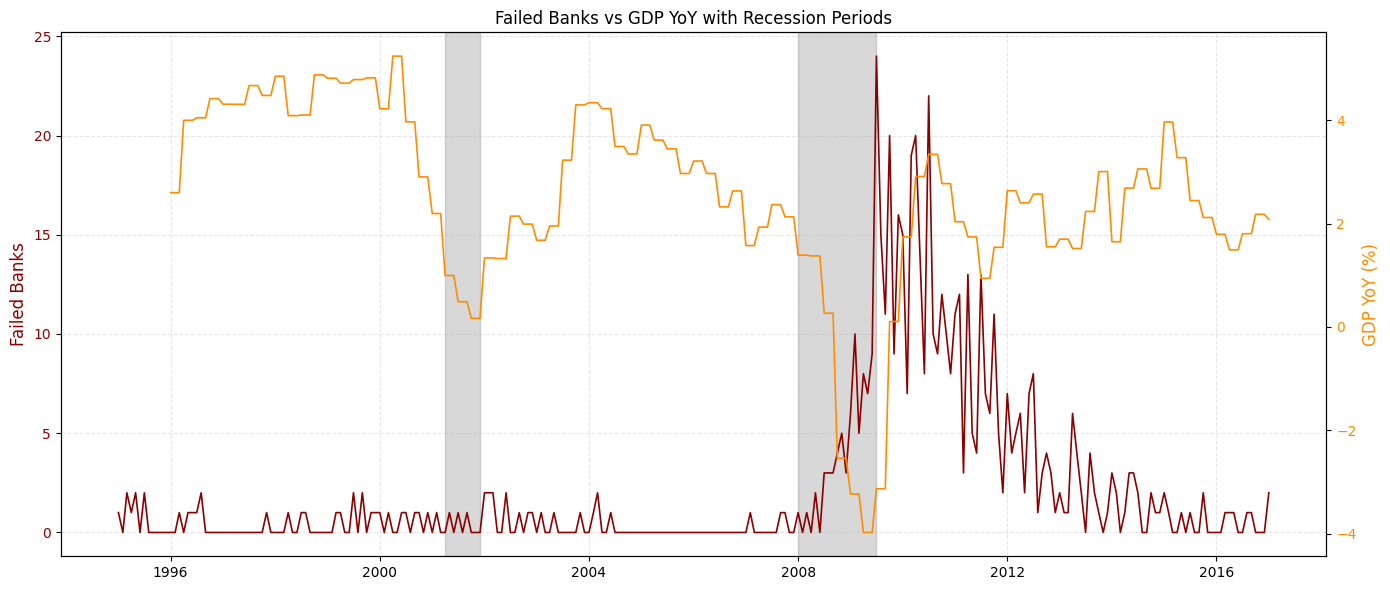

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and clean bank failures
banks = pd.read_csv("banks.csv", parse_dates = ["Failure Date"])
banks["Date"] = banks["Failure Date"].dt.to_period("M").dt.to_timestamp()
banks_monthly = banks.groupby("Date").size().reset_index(name = "Failed Banks")

# Fill in missing months with 0s
full_range = pd.date_range(start = banks_monthly["Date"].min(), end = banks_monthly["Date"].max(), freq = "MS")
banks_monthly = pd.merge(pd.DataFrame({"Date": full_range}), banks_monthly, on = "Date", how = "left")
banks_monthly["Failed Banks"] = banks_monthly["Failed Banks"].fillna(0)
banks_monthly = banks_monthly[banks_monthly["Date"] >= "1995-01-01"]

# Load CPI and compute YoY
cpi = pd.read_csv("CPIAUCSL.csv", parse_dates = ["observation_date"])
cpi = cpi.rename(columns = {"observation_date": "Date", "CPIAUCSL": "CPI"})
cpi["CPI_YoY"] = cpi["CPI"].pct_change(periods=12) * 100

# Load recession indicator
recessions = pd.read_csv("USREC.csv", parse_dates = ["observation_date"])
recessions = recessions.rename(columns = {"observation_date": "Date", "USREC": "Recession"})

# Load GDP and compute YoY
gdp = pd.read_csv('GDPC1.csv', parse_dates = ["observation_date"])
gdp = gdp.rename(columns = {"observation_date": "Date", "GDPC1": "GDP"})
gdp["GDP_YoY"] = gdp["GDP"].pct_change(periods = 4) * 100

# Resample GDP to monthly frequency using forward fill
gdp = gdp.set_index("Date").resample('MS').ffill()

# Merge
merged_data = pd.merge(banks_monthly, cpi[["Date", "CPI_YoY"]], on = "Date", how = "left")
merged_data = pd.merge(merged_data, recessions, on = "Date", how = "left")
merged_data = pd.merge(merged_data, gdp[["GDP_YoY"]], on = "Date", how = "left")
merged_data["Recession"] = merged_data["Recession"].fillna(0)

# Plot
def plot_banks_vs_gdp(title: str):
    fig, ax1 = plt.subplots(figsize = (14, 6))

    ax1.plot(merged_data["Date"], merged_data["Failed Banks"], color = "darkred", linewidth = 1.2)
    ax1.set_ylabel("Failed Banks", color = "darkred", fontsize = 12)
    ax1.tick_params(axis = 'y', labelcolor = "darkred")
    ax1.grid(True, linestyle = "--", alpha = 0.3)

    ax2 = ax1.twinx()
    ax2.plot(merged_data["Date"], merged_data["GDP_YoY"], color = "darkorange", linewidth = 1.2)
    ax2.set_ylabel("GDP YoY (%)", color = "darkorange", fontsize = 12)
    ax2.tick_params(axis = 'y', labelcolor = "darkorange")

    recession_mask = merged_data["Recession"] == 1
    for i in range(1, len(recession_mask)):
        if recession_mask.iloc[i] and not recession_mask.iloc[i - 1]:
            start = merged_data["Date"].iloc[i]
        if recession_mask.iloc[i - 1] and not recession_mask.iloc[i]:
            end = merged_data["Date"].iloc[i]
            ax1.axvspan(start, end, color = "gray", alpha = 0.3)

    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_banks_vs_gdp("Failed Banks vs GDP YoY with Recession Periods")

## FB vs. INDPRO

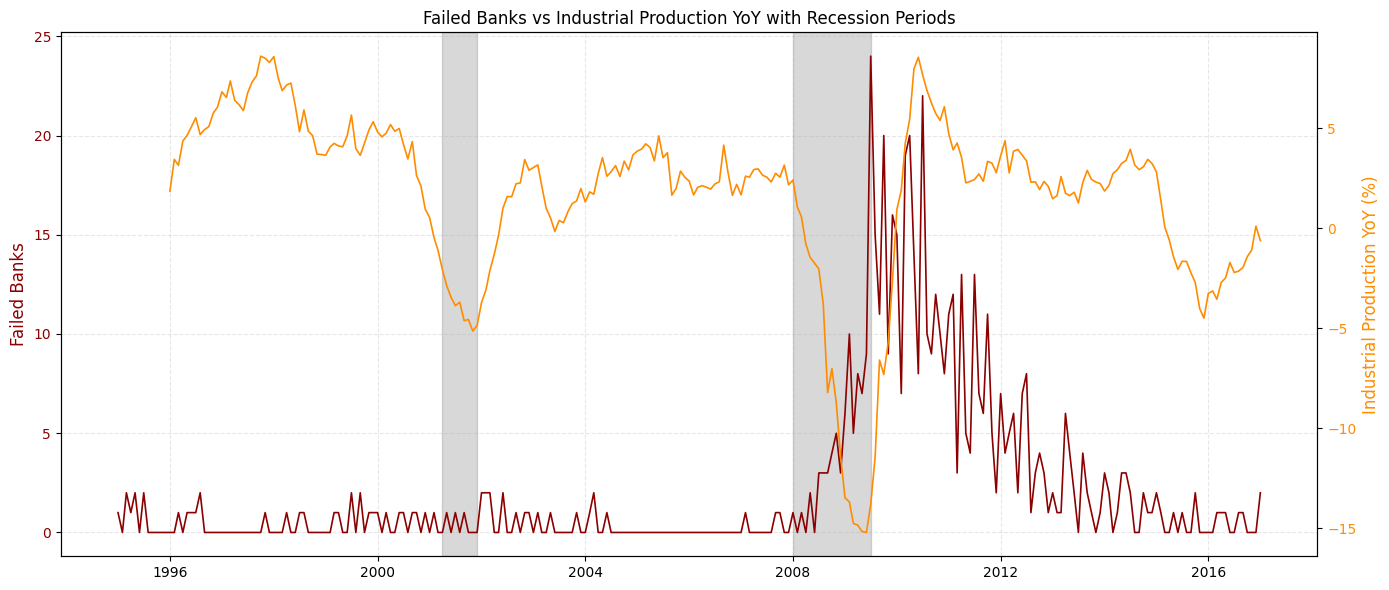

In [ ]:
# Load INDPRO and compute YoY
ind = pd.read_csv("INDPRO.csv", parse_dates = ["observation_date"])
ind = ind.rename(columns = {"observation_date": "Date", "INDPRO": "IND"})
ind["IND_YoY"] = ind["IND"].pct_change(periods = 12) * 100

# Merge
merged_data = pd.merge(merged_data, ind[["Date", "IND_YoY"]], on = "Date", how = "left")

# Plot
def plot_banks_vs_indpro(title: str):
    fig, ax1 = plt.subplots(figsize = (14, 6))

    ax1.plot(merged_data["Date"], merged_data["Failed Banks"], color = "darkred", linewidth = 1.2)
    ax1.set_ylabel("Failed Banks", color = "darkred", fontsize = 12)
    ax1.tick_params(axis = 'y', labelcolor = "darkred")
    ax1.grid(True, linestyle = "--", alpha = 0.3)

    ax2 = ax1.twinx()
    ax2.plot(merged_data["Date"], merged_data["IND_YoY"], color = "darkorange", linewidth = 1.2)
    ax2.set_ylabel("Industrial Production YoY (%)", color = "darkorange", fontsize = 12)
    ax2.tick_params(axis = 'y', labelcolor = "darkorange")

    recession_mask = merged_data["Recession"] == 1
    for i in range(1, len(recession_mask)):
        if recession_mask.iloc[i] and not recession_mask.iloc[i - 1]:
            start = merged_data["Date"].iloc[i]
        if recession_mask.iloc[i - 1] and not recession_mask.iloc[i]:
            end = merged_data["Date"].iloc[i]
            ax1.axvspan(start, end, color = "gray", alpha=  0.3)

    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_banks_vs_indpro("Failed Banks vs Industrial Production YoY with Recession Periods")


## FB vs. ICSA

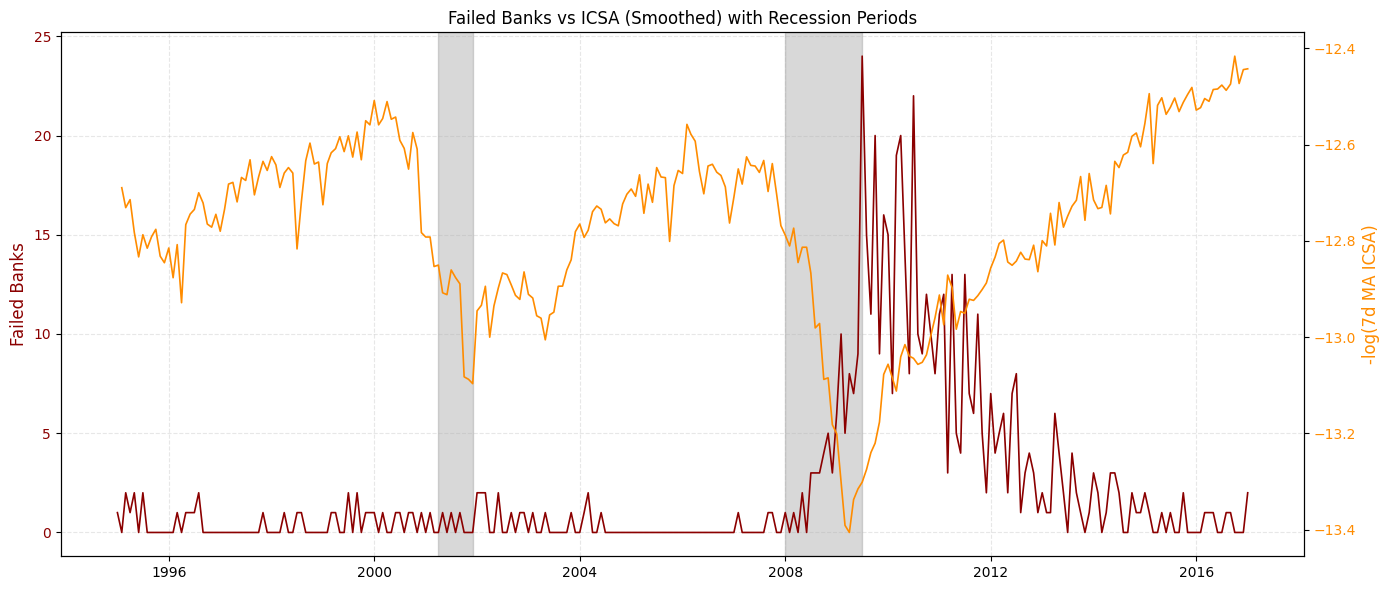

In [ ]:
# Load and smooth ICSA
icsa = pd.read_csv("ICSA.csv", parse_dates = ["observation_date"])
icsa = icsa.rename(columns = {"observation_date": "Date", "ICSA": "ICSA"})
icsa = icsa[["Date", "ICSA"]]
icsa = icsa.set_index("Date").sort_index().resample("D").ffill().reset_index()
icsa["ICSA_smooth"] = -np.log(icsa["ICSA"].rolling(window = 7).mean())

# Merge
merged_data = pd.merge(merged_data, icsa[["Date", "ICSA_smooth"]], on = "Date", how = "left")

# Plot
def plot_banks_vs_icsa(title: str):
    fig, ax1 = plt.subplots(figsize = (14, 6))

    ax1.plot(merged_data["Date"], merged_data["Failed Banks"], color = "darkred", linewidth = 1.2)
    ax1.set_ylabel("Failed Banks", color = "darkred", fontsize = 12)
    ax1.tick_params(axis = 'y', labelcolor = "darkred")
    ax1.grid(True, linestyle = "--", alpha = 0.3)

    ax2 = ax1.twinx()
    ax2.plot(merged_data["Date"], merged_data["ICSA_smooth"], color = "darkorange", linewidth = 1.2)
    ax2.set_ylabel("-log(7d MA ICSA)", color = "darkorange", fontsize = 12)
    ax2.tick_params(axis = 'y', labelcolor = "darkorange")

    recession_mask = merged_data["Recession"] == 1
    for i in range(1, len(recession_mask)):
        if recession_mask.iloc[i] and not recession_mask.iloc[i - 1]:
            start = merged_data["Date"].iloc[i]
        if recession_mask.iloc[i - 1] and not recession_mask.iloc[i]:
            end = merged_data["Date"].iloc[i]
            ax1.axvspan(start, end, color = "gray", alpha = 0.3)

    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_banks_vs_icsa("Failed Banks vs ICSA (Smoothed) with Recession Periods")

In [ ]:
pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.6.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.6
ale-py                                0.11.0
altair                                5.5.0
annotated-types                       0.7.0
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.0.1
astropy-iers-data                     0.2025.4.28.0.37.27
astunparse                            1.6.3
atpublic                              5